# Creation of our own model

In [1]:
from carRecognition import CarRecognitionDataset, display_bounding_boxes

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from skimage import io
import pandas as pd

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [2]:
# Global variables

NEW_X = 338
NEW_Y = 190

In [3]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.ToTensor())

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [5]:
def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (image, box) in enumerate(train_loader):
            image=image.float()
            box=box.float()
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, box)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
        
        # correct = 0
        # for x, y in test_loader:
        #     z = model(x.view(-1, 128 * 128 * 3))
        #     _, label = torch.max(z, 1)
        #     print(z)
        #     correct += (label == y).sum().item()
    
        # accuracy = 100 * (correct / len(test_loader))
        # output['test_accuracy'].append(accuracy)
    
    return output

In [6]:
# https://www.youtube.com/watch?v=pDdP0TFzsoQ&ab_channel=PatrickLoeber

class CarRecognitionNet(nn.Module):
    def __init__(self, in_size):
        super(CarRecognitionNet, self).__init__()
        # 338, 190
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        # 336, 188
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 168, 94
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        # 166, 92

        self.dynamic_input = int(((((NEW_Y-2)//2)-2)//2) * ((((NEW_X-2)//2)-2)//2) * 32)
        # pseudo-dynamic output of the conv layers

        self.fc1 = nn.Linear(self.dynamic_input, 128)
        self.fc2 = nn.Linear(128, 4) # 4 for the coordinates (x_min, y_min, x_max, y_max)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(-1, self.dynamic_input) # -1 should be batch_size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # coordinates prediction
        return x
    

In [7]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.001
epochs = 10
model = CarRecognitionNet(NEW_X*NEW_Y*3) # image size et 3 canaux RGB

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, val_loader, optimizer, epochs)




done


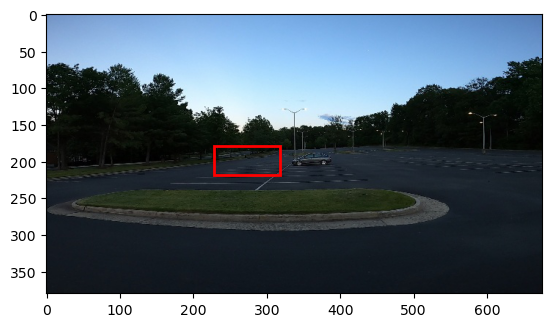

In [8]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

image_path = 'data/test/vid_5_400.jpg'
image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize((NEW_X,NEW_Y)),
                                transforms.ToTensor()])
img = transform(image)
img = img.unsqueeze(0) # simuler un batch size de 1 pour avoir la bonne dim
pred = model(img)
display_bounding_boxes(image, pred)

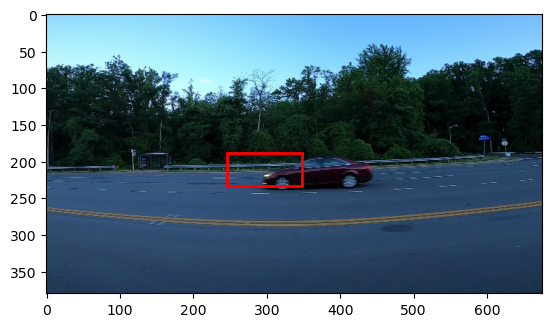

In [11]:
# image_path = 'data/test/vid_5_27900.jpg'
image_path = 'data/train/vid_4_860.jpg'
image = Image.open(image_path)


transform = transforms.Compose([transforms.Resize((NEW_X,NEW_Y)),
                                transforms.ToTensor()])
img = transform(image)
img = img.unsqueeze(0) # simuler un batch size de 1 pour avoir la bonne dim

pred = model(img)
display_bounding_boxes(image, pred)

In [24]:
image_path = 'data/test/vid_5_400.jpg'
image = Image.open(image_path)


transform = transforms.Compose([transforms.Resize((NEW_X,NEW_Y)),
                                transforms.ToTensor()])
img = transform(image)
# img = img.unsqueeze(0) # simuler un batch size de 1 pour avoir la bonne dim


In [25]:
conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
# 334, 186 (input - kernelsize + 1)
pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
# 166, 93
conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
# 162, 89

fc1 = nn.Linear(166*92*32, 128)  # Modifiez selon la taille de votre image
fc2 = nn.Linear(128, 4)  # 4 pour les coordonnées (x_min, y_min, x_max, y_max)

print(img.shape)
x  = conv1(img)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)



torch.Size([3, 338, 190])
torch.Size([16, 336, 188])
torch.Size([16, 168, 94])
torch.Size([32, 166, 92])
torch.Size([32, 83, 46])


In [26]:
# torch.Size([1, 3, 338, 190])
# torch.Size([1, 16, 336, 188])
# torch.Size([1, 16, 168, 94])
# torch.Size([1, 32, 166, 92])